## ***Formulas***

$\textbf{X} \in \mathbb{R}^{m \times n}; \quad \textbf{W} \in \mathbb{R}^{h \times n}; \quad \textbf{b}_1 \in \mathbb{R}^{h \times 1}$

$\textbf{ReLU}\{\textbf{W} \cdot \textbf{X}^\text{T} + \textbf{b}_1\} = \textbf{H} \in \mathbb{R}^{h \times m}$

$\textbf{U} \in \mathbb{R}^{10 \times h}; \quad \textbf{b}_2 \in \mathbb{R}^{10 \times 1}$

$\textbf{U} \cdot \textbf{H} + \textbf{b}_2 = \textbf{O} \in \mathbb{R}^{10 \times m}$

$\textbf{P} = \textbf{softmax}(O, \text{axis}=0)$

$\text{classes} = \textbf{argmax}(\textbf{P}, \text{axis}=0)$

## ***Import libraries***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

In [ ]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "gray"}
sns.set_style("darkgrid", rc = custom)

## ***Import data MNIST***

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [ ]:
def plot_img(img, label):
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(img.reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

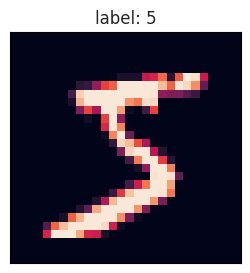

In [ ]:
plot_img(X_train[0], f'label: {y_train[0]}')

## ***Create network structure***

In [ ]:
class Net:
    def __init__(self, input_dim, hidden_dim, output_dim, lr, epochs, bs):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.epochs = epochs
        self.bs = bs

        self.W1 = np.random.randn(self.hidden_dim, self.input_dim) * np.sqrt(2. / self.input_dim)
        self.b1 = np.random.randn(self.hidden_dim, 1)
        self.W2 = np.random.randn(10, self.hidden_dim) * np.sqrt(2. / self.hidden_dim)
        self.b2 = np.random.randn(10, 1)

    def forward(self, X, train=False):
        H1 = self.W1 @ X.T + self.b1
        H1_act = self.ReLU(H1)

        H2 = self.W2 @ H1_act + self.b2
        H2_act = self.softmax(H2)

        if train:
            return H1, H1_act, H2, H2_act

        return H2_act

    def backward(self, H1, H1_act, H2, H2_act, one_hot_y, X):
        r, _ = X.shape

        dL_H2 = H2_act - one_hot_y.T  # output_dim x batch_size

        dW2 = dL_H2 @ H1_act.T / r  # output_dim x hidden_dim
        db2 = np.sum(dL_H2, axis=1, keepdims=True) / r  # output_dim x 1

        dH1 = (self.W2.T @ dL_H2) * (H1 > 0)  # hidden_dim x batch_size
        dW1 = dH1 @ X / r  # hidden_dim x input_dim
        db1 = np.sum(dH1, axis=1, keepdims=True) / r  # hidden_dim x 1

        self.W1 -= dW1 * self.lr
        self.W2 -= dW2 * self.lr
        self.b1 -= db1 * self.lr
        self.b2 -= db2 * self.lr

    def fit(self, X, y):
        for epoch in range(self.epochs):
            epoch_loss = 0
            for i in range(self.bs, X.shape[0], self.bs):
                X_batch = X[i-self.bs:i]
                y_batch = y[i-self.bs:i].reshape(-1, 1)

                H1, H1_act, H2, H2_act = self.forward(X_batch, train=True)

                one_hot_y = self.one_hot(y_batch)

                loss = self.compute_loss(one_hot_y, H2_act)
                epoch_loss += loss

                self.backward(H1, H1_act, H2, H2_act, one_hot_y, X_batch)

            if epoch == self.epochs - 1:
                print("")

            print(f"loss: {epoch_loss / (X.shape[0] // self.bs)}\n")

    def predict(self, X_test):
        y_pred = self.forward(X_test)
        return np.argmax(y_pred, axis=0)

    def ReLU(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    def one_hot(self, y):
        one_hot_y = np.zeros((y.size, self.output_dim))
        one_hot_y[np.arange(y.size), y.flatten()] = 1

        return one_hot_y

    def compute_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred.T + 1e-9)) / y_true.shape[0]

In [ ]:
input_dim = 784
hidden_dim = 512
output_dim = np.unique(y_train).shape[0]
lr = 0.1
epochs = 5
bs = 32

In [ ]:
model = Net(input_dim, hidden_dim, output_dim, lr, epochs, bs)

## ***Create train process***

In [ ]:
model.fit(X_train, y_train)

loss: 0.3000913186259314

loss: 0.13419676657965082

loss: 0.09302563186224966

loss: 0.07093867537620505


loss: 0.05645416048461488



## ***Prediction of model***

In [ ]:
y_pred = model.predict(X_test)
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')

Accuracy = 0.9755
